In [1]:
import sys
import os
sys.path.append('..')
print(sys.path)
from tools.fetching_description_from_huggingface import fetching_description_from_huggingface
from tools.column_parser import column_parser
from typing import TypedDict, Annotated, List
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain.agents import create_tool_calling_agent, AgentExecutor
from pydantic import BaseModel, Field
from langchain.tools import Tool
from firecrawl import FirecrawlApp
from langchain_core.output_parsers import PydanticOutputParser
import pandas as pd
import pprint
from dotenv import load_dotenv
from enum import Enum

['/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/mnt/g/Ai agents course/LangGraph/venv/lib/python3.12/site-packages', '..']


In [2]:
load_dotenv(override=True)

True

In [3]:
OPENAI_API_KEY='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'
BASE_URL='https://api.groq.com/openai/v1'
MODEL="meta-llama/llama-4-scout-17b-16e-instruct"

In [4]:
df_task = pd.read_csv("../Test/data/ISE - AutoCode Challenge 2 Public - Public task.csv")
df_model = pd.read_csv("../Test/data/ISE - AutoCode Challenge 2 Public - Model zoo.csv")

In [5]:
df_task

,STT,Task,Validation data
0,1,"""Bối cảnh của vấn đề:\r\nNhận dạng chữ viết ta...",Link
1,2,Bối cảnh của vấn đề:\r\nTrong thời đại thông t...,Link
2,3,Bối cảnh của vấn đề:\r\nĐây là một nhiệm vụ hồ...,Link
3,4,Bối cảnh của vấn đề:\r\nĐiều quan trọng là các...,Link
4,5,Bối cảnh của vấn đề:\r\nTrong nhiều ứng dụng t...,Link
5,6,🐾 Story: Alice’s Magical Pet Photo Box\r\nAlic...,Link


In [6]:
def format_model_list(df):
    model_strings = []
    for i, row in df.iterrows():
        desc = str(row[1]).replace("{", "{{").replace("}", "}}")
        url = str(row[2])
        model_strings.append(f"{i + 1} - {desc} [More info]({url})")
    return "\n".join(model_strings)


In [7]:
def web_scraper(url: str) -> str:
    """Get more details about the model using the model url"""
    # scraper = FirecrawlApp(api_key=os.getenv("FIRECRAWL_API_KEY"))
    # scrape_status = scraper.scrape_url(
    #     url,
    #     formats=['markdown']
    # )
    # return scrape_status.markdown
    result = fetching_description_from_huggingface(url)
    return result

In [8]:
class WebScraperParameters(BaseModel):
    url: str

In [9]:
res = web_scraper('https://huggingface.co/thanhtlx/image_classification_01')

In [10]:
def data_preview(path: str):
    """Get data preview"""
    result = column_parser(path, 5)
    return result

In [12]:
tools = [
    Tool(
        name="web_scrapper",
        func=web_scraper,
        description="Use to get more detail about the model",
        args_schema=WebScraperParameters
    )
]

In [13]:
class Error(Enum):
    MODEL_TOOL_ERROR = "model_tool_error"

In [14]:
class Tasks(BaseModel):
    subtask_one: str = Field(
        ...,
        description="Detailed description of task 1"
    )
    subtask_two: str = Field(
        ...,
        description="Detailed description of task 2"
    )
    subtask_three: str = Field(
        ...,
        description="Detailed description of task 3"
    )
    subtask_four: str = Field(
        ...,
        description="Detailed description of task 4"
    )

In [15]:
class ModelInfo(BaseModel):
    model: str = Field(..., description="Model name and description")
    url: str = Field(..., description="URL to the model")

class ModelSelection(BaseModel):
    models: List[ModelInfo] = Field(..., description="List of available models with name and URL")

In [16]:
class ModelingOutput(BaseModel):
    model_description: str = Field(
        ...,
        description="The detailed description of the model."
    )
    model_input_format: str = Field(
        ...,
        description="Model's detailed input format"
    )
    model_output_format: str = Field(
        ...,
        description="Model's detailed output format"
    )
    model_requirements: str = Field(
        ...,
        description="Requirement libraries need to install to use the model."
    )
    model_sample_code: str = Field(
        ...,
        description="Example code to use the model"
    )

class ModelList(BaseModel):
    models: List[ModelingOutput] = Field(
        ...,
        description="List of suitable model for given task"
    )

In [17]:
class Dependencies(BaseModel):
    dependencies: List[str] = Field(
        ...,
        description="List of dependencies that needed to be install"
    )

In [18]:
llm = ChatOpenAI( 
    base_url=BASE_URL,
    model=MODEL,
    api_key=OPENAI_API_KEY,
    temperature=0.3
)

In [19]:
class AgentState(TypedDict):
    task: HumanMessage | None
    data: str | None
    messages: Annotated[List[BaseMessage], add_messages]
    subtasks: Tasks
    models: ModelSelection
    model_description: str
    model_detailed_list: ModelList
    output_classes: str | None
    code: str | None
    improved_code: str | None
    evaluation_summary: str | None
    dependencies: Dependencies | None
    error: str | None

In [20]:
def classify_agent(state: AgentState) -> AgentState:
    structured_llm = llm.with_structured_output(Tasks)
    system_prompt = """
        You are an expert in task formulation. Given a machine learning task, you will
        help divide the task into these subtasks:
        - Subtask1: for identifying task description and classify the problem type.
        - Subtask2: for identifying the problem requirements as described in the "Yêu cầu cụ thể cần đạt được" (or other equivalent) section, including: problem requirements, expected input and expected output.
        - Subtask3: for identifying the input format of the problem, as being described in the "Định dạng dữ liệu đầu vào cho bài toán tổng thể" (or other equivalent) section.
        - Subtask4: for identifying the output format of the problem with the given classes, as being described in the "Định dạng kết quả đầu ra mong muốn cho bài toán tổng thể" (or other equivalent) section.

        You **MUST** follow these guidelines:
        - Do not mistake the output classes with the one described in the problem requirements. The output classes **MUST** contain the classes described in the "Định dạng kết quả đầu ra mong muốn cho bài toán tổng thể" section.
        - Describe the subtasks as specific as possible.
        """
    messages = [SystemMessage(content=system_prompt)]
    messages.append(state['task'])
    result = structured_llm.invoke(messages)
    state['subtasks'] = result
    return state

In [21]:
task = df_task["Task"][5]

In [22]:
state = {
    "task": HumanMessage(content=task),
    "messages": []
}

In [23]:
state = classify_agent(state)

In [24]:
pprint.pprint(state['subtasks'].subtask_one)
pprint.pprint(state['subtasks'].subtask_two)
pprint.pprint(state['subtasks'].subtask_three)
pprint.pprint(state['subtasks'].subtask_four)


('Identify the task description and classify the problem type. The task is to '
 'build an intelligent system that can analyze images of pets and classify '
 'them into categories such as dogs, cats, or unclear images. The problem type '
 'is a multi-class image classification problem with specific requirements for '
 'each class.')
('Identify the problem requirements. The system should:\n'
 '  - Detect all visible dogs in an image and identify their breed.\n'
 '  - Return the most frequent breed in the image if there are multiple dogs.\n'
 '  - Determine the emotion of a single cat in an image (happy, angry, '
 'curious, or relaxed).\n'
 "  - Return 'unsure' if the image is unclear or does not contain a visible "
 'pet.\n'
 '  - The expected input is an image file in .jpg or .png format.\n'
 '  - The expected output is a CSV file with the image filename without '
 'extension (id) and the prediction (most frequent dog breed, cat emotion, or '
 "'unsure').")
('Identify the input format 

In [25]:
model_selection_parser = PydanticOutputParser(pydantic_object=ModelSelection)

In [26]:
def model_selection_agent(state: AgentState):
    system_prompt = """
                    You are a machine learning expert assigned to select the suitable model for a given task.
                    Given:
                    - A user description about the task
                    - A list of available model (names and links)
                    Your job is to choose ALL suitable models provided in the list for user's specific tasks.
                    Return the answer in the format
                    {structured_output}
                    Here are the list of model:
                    {model_list}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", "{input}")
    ]).partial(structured_output=model_selection_parser.get_format_instructions())

    chain = prompt | llm | model_selection_parser

    result = chain.invoke({"input": state['task'], "model_list": format_model_list(df_model)})
    state['models'] = result
    return state

In [27]:
state = model_selection_agent(state)
pprint.pprint(state['models'].models)

/tmp/ipykernel_3133/7332665.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desc = str(row[1]).replace("{", "{{").replace("}", "}}")
/tmp/ipykernel_3133/7332665.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  url = str(row[2])


[ModelInfo(model='Phân loại hình ảnh giống chó', url='https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit'),
 ModelInfo(model='Nhận diện cảm xúc mèo', url='https://huggingface.co/semihdervis/cat-emotion-classifier'),
 ModelInfo(model='Phân loại hình ảnh thành100 lớp đối tượng chi tiết (fine-grained)', url='https://huggingface.co/zhaospei/Model_6')]


In [28]:
def model_selection_using_tool_agent(state: AgentState):
    system_prompt = """
                    You are a machine learning expert assigned to select the **Best-fit model** for a given task.
                    Given:
                    - A user task description
                    - A list of available models (names and url)
                    - A tool that fetches model details from a provided URL (it help gathers model description, input/output format, code sample usage)

                    Your job is to:
                    1. Use the **provided tool** to retrieve real details about each candidate model:
                        - ✅ Model description
                        - 📥 Input format
                        - 📤 Output format
                        - 🛠️ Library requirements
                        - 🧪 Code sample (usage code snippet)
                    2. Select the best model for user given task based on the data that the tool gives you.

                    ⚠️ VERY IMPORTANT RULES

                    - ❌ DO NOT assume or invent any part of the model's description, input/output format, requirements or code
                    - ❌ DO NOT generate fake code or use your own knowledge about the model
                    - ✅ ONLY use the **actual output** returned from the tool
                    - ✅ Include tool content in your final answer exactly as returned (especially code)

                    ## 🧠 Output Structure (Final Answer)

                    After retrieving tool results, choose best-fit model for the task (You may need to choose more than one model for some tasks), only choose the model 
                    that strictly relevant to the task and only return the output of the model result in the following format:

                    **✅ Model name and link**  
                    `<model name>` — `<link>`

                    **📝 Description (from tool):**  
                    <model description>

                    **📥 Input format (from tool):**  
                    <description of expected input>

                    **📤 Output format (from tool):**  
                    <description of model output>

                    **🛠️ Library Requirements (from tool) **
                    <requirements to use the model>

                    **🧪 Example code (from tool):**  
                    ```python
                    <exact code snippet from tool>

                    You MUSTN'T return any of your thought process, only the model details.

                    Here are the list of models and there corresponding URL:
                    {model_list}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("ai", "{agent_scratchpad}"),
        ("human", "{input}")
    ])

    agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)
    try:
        result = executor.invoke({"input": state['task'], "model_list": state['models'].models})
        state['model_description'] = result['output']
        return state
    except Exception as e:
        print(f"Error occur in model selection tool calling phase: {e}")
        state['error'] = Error.MODEL_TOOL_ERROR
        return state

In [29]:
state = model_selection_using_tool_agent(state)



> Entering new AgentExecutor chain...

Invoking: `web_scrapper` with `{'url': 'https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit'}`
responded: To solve this task, we need to analyze the requirements and select the best-fit model for each part of the task: dog breed identification and cat emotion recognition.

First, let's analyze the models provided:

1. **Phân loại hình ảnh giống chó** (Dog Breed Classification): This model is likely to be used for identifying dog breeds in images.
2. **Nhận diện cảm xúc mèo** (Cat Emotion Recognition): This model is likely to be used for recognizing emotions in cat faces.
3. **Phân loại hình ảnh thành 100 lớp đối tượng chi tiết (fine-grained)** (Fine-grained Image Classification): This model might be too general and not specifically tailored for dog breed identification or cat emotion recognition.

Let's gather more information about the first two models:




Model made by notebook first posted in my Kaggle.
Mo

In [30]:
pprint.pprint(state['model_description'])

('## ✅ Model name and link\n'
 '`Phân loại hình ảnh giống chó` — '
 '`https://huggingface.co/wesleyacheng/dog-breeds-multiclass-image-classification-with-vit`\n'
 '\n'
 '## 📝 Description (from tool):\n'
 'This model is finetuned using the Google Vision Transformer '
 '(vit-base-patch16-224-in21k) on the Stanford Dogs dataset in Kaggle to '
 'classify dog images into 120 types of dog breeds.\n'
 '\n'
 '## 📥 Input format (from tool):\n'
 '- Input: Dog images\n'
 '- Format: RGB images\n'
 '- Size: Not specified\n'
 '\n'
 '## 📤 Output format (from tool):\n'
 '- Output: Predicted dog breed class\n'
 '- Format: logits\n'
 '- Data type: Tensor\n'
 '\n'
 '## 🛠️ Library Requirements (from tool)\n'
 '```bash\n'
 'pip install transformers torch torchvision\n'
 '```\n'
 '\n'
 '## 🧪 Example code (from tool):\n'
 '```python\n'
 'from transformers import AutoImageProcessor, '
 'AutoModelForImageClassification\n'
 'import PIL\n'
 'import requests\n'
 '\n'
 'url = "https://upload.wikimedia.org/wikipedi

In [31]:
parser = PydanticOutputParser(pydantic_object=ModelList)

In [32]:
output_parser_llm = ChatOpenAI(
    base_url=BASE_URL,
    model=MODEL,
    api_key=OPENAI_API_KEY,
    temperature=0.3
)

In [ ]:
def recovery_parser_agent(state: AgentState):
    recovery_prompt = """
        The previous attempt to extract structured data failed.
        You must now attempt to salvage **as much accurate information as possible** from the input text.

        Try to extract the following fields. It's okay to leave some fields blank if information isn't available:
        - `model_description`
        - `model_input_format`
        - `model_output_format`
        - `model_requirements`
        - `model_sample_code`

        Do NOT make up any data. Only extract what you are certain is present in the input.

        Format your output as JSON:
        {formatted_output}
    """
    prompt = ChatPromptTemplate.from_messages([
        ('system', recovery_prompt),
        ('human', "{input}")
    ]).partial(formatted_output=parser.get_format_instructions())

    chain = prompt | output_parser_llm | parser
    try:
        response = chain.invoke({"input": state['model_description']})
        state['model_detailed_list'] = response
        state['recovery_used'] = True
    except Exception as e:
        print(f"❌ Recovery also failed: {e}")
        state['model_detailed_list'] = {
            "error": "Both primary and recovery parsing failed.",
            "details": str(e),
            "raw_input": state.get('model_description', '')
        }
        state['recovery_used'] = True
    return state


In [ ]:
def output_parser_agent(state: AgentState):
    system_prompt = """
                    You are a smart AI tasked with extracting structured technical details about a machine learning model from a reasoning result.
                    You are given a detailed text description about a model (or a list of model).
                    Your goal is to fill the following fields using the data about chosen models based on the text:

                    - `model_description`: A detailed explanation of what the model is and what it does.
                    - `model_input_format`: A detailed description of the model's input format, including dimensions, data types, and expected preprocessing if mentioned.
                    - `model_output_format`: A detailed description of the output format including dimensions, data types, label name and its meaning.
                    - `model_requirements`: A detailed description about the requirements needed to be sastified in order to use the model
                    - `model_sample_code`: A sample code on how to use the model.

                    You MUSTN'T create any data on your own, only using the data provided in the text.

                    Return the data as a JSON object matching the following structure:
                    {formatted_output}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ('system', system_prompt),
        ('human', "{input}")
    ]).partial(formatted_output=parser.get_format_instructions())
    chain = prompt | output_parser_llm | parser
    try:
        response = chain.invoke({"input": state['model_description']})
        state['model_detailed_list'] = response
    except Exception as e:
        print(f"⚠️ Output parsing failed: {e}")
        # Optional: fallback, recovery, or debug output
        state['model_detailed_list'] = {
            "error": "Failed to parse output",
            "details": str(e),
            "raw_input": state.get('model_description', '')
        }
        state = recovery_parser_agent(state)
    return state

In [35]:
state = output_parser_agent(state)

In [36]:
ans = state['model_detailed_list']
for i in range(len(ans.models)):
    print(f"Model {i}:")
    pprint.pprint(ans.models[i].model_description)
    pprint.pprint(ans.models[i].model_input_format)
    pprint.pprint(ans.models[i].model_output_format)
    pprint.pprint(ans.models[i].model_requirements)
    pprint.pprint(ans.models[i].model_sample_code)

Model 0:
('This model is finetuned using the Google Vision Transformer '
 '(vit-base-patch16-224-in21k) on the Stanford Dogs dataset in Kaggle to '
 'classify dog images into 120 types of dog breeds.')
'Input: Dog images, Format: RGB images, Size: Not specified'
'Output: Predicted dog breed class, Format: logits, Data type: Tensor'
'pip install transformers torch torchvision'
('from transformers import AutoImageProcessor, '
 'AutoModelForImageClassification\n'
 'import PIL\n'
 'import requests\n'
 '\n'
 'url = "https://upload.wikimedia.org/wikipedia/commons/5/55/Beagle_600.jpg"\n'
 'image = PIL.Image.open(requests.get(url, stream=True).raw)\n'
 'image_processor = '
 'AutoImageProcessor.from_pretrained("wesleyacheng/dog-breeds-multiclass-image-classification-with-vit")\n'
 'model = '
 'AutoModelForImageClassification.from_pretrained("wesleyacheng/dog-breeds-multiclass-image-classification-with-vit")\n'
 'inputs = image_processor(images=image, return_tensors="pt")\n'
 'outputs = model(**

In [37]:
def output_agent(state: AgentState) -> AgentState:
    prompt = r"""
        Your are a specialist in machine learning. Your task is to identify the absolute classes of the given problem description, following with an output description.
        ### Input:
        - Problem description: {problem_description}
        - Output description: {output_description}

        You must return an array, strictly following these guidelines:
        - Understand the context from the given problem description.
        - Extract the class names from the output description. You **must not** invent new labels or translate the class names. Use them exactly as given in the output description.
        - Create an array containing the classes.

        You must return only the array containing those classes, without any formatting.
    """

    prompt = prompt.format(
        problem_description = state['task'],
        output_description = state["subtasks"].subtask_four
    )
    response = llm.invoke(prompt)
    return {**state, "output_classes": response.content}

In [38]:
state = output_agent(state)
print(state['output_classes'])

unsure
happy
angry
curious
relaxed 
unsure 
bulldog 
beagle 
poodle 
pug 
 Chihuahua 
 Labrador 
German Shepherd 
Golden Retriever 
French Bulldog 
Shih Tzu 
Yorkshire Terrier 
Boxer 
Dachshund 
Great Dane 
Rottweiler 
Australian Shepherd 
Corgi 
Doberman 
Pitbull 
Cocker Spaniel 
 Afghan Hound 
Basenji 
Basset Hound 
Bloodhound 
Border Collie 
Cane Corso 
Cardigan Welsh Corgi 
Cavalier King Charles Spaniel 
Chow Chow 
Dalmatian 
Greyhound 
Havanese 
Maltese 
Papillon 
Pomeranian 
Pug 
Rhodesian Ridgeback 
Shetland Sheepdog 
Siberian Husky 
Tibetan Spaniel 
Vizsla 
Weimaraner 
Welsh Springer Spaniel 
Wire Fox Terrier


In [39]:
llm_coding = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    model=os.getenv("MODEL_NAME"),
    temperature=0.5
)

In [40]:
def coding_agent(state: AgentState) -> AgentState:
    base_prompt = r"""
    You are a specialist in Machine Learning. Your task is to generate a *fully functional with all necessary imports and dependencies* codebase in *Python* that can be executed flawlessly.

    You will be provided with:
    - A problem description
    - An input specification
    - An output specification
    - A description of models that you needed to use
    - A list of model to use to solve the problem

    ### Input:
    - Problem description: {problem_description}
    - Problem input specification: {problem_input_description}
    - Problem output specification: {problem_output_description}
    - ML Model list and there detailed description: {model_list}
    - Output classes: {output_classes}

    ### Guidelines

    You *must* strictly follow the following guidelines:
    - DO NOT generate any new input. ONLY use the given input file form the problem input description provided above.
    - If NO input file is provided, assume that the input file will be "test.csv"
    - The preprocessing step should be suitable for the data type.
    - The postprocessing step should notices the differences between the data returned by the model and the output requirements. You must extract and use the exact class labels as defined in the output specification.
    - Do *not invent new labels or translate* the class names. Use them exactly as given.
    - You *must* make sure that your codebase can be executed flawlessly that would not encounter any errors or exceptions.
    - You must add some tqdm to see the infer progress.
    - Output file name MUST be "predictions.csv"

    Your implementation *must strictly follow* the structure below:
    1. *Imports*: All required libraries.
    2. *Preprocessing*: Handle and transform the input as defined.
    3. *Inference logic*: Use the described model for prediction. You *must* use tqdm or similar logging library to track progress.
    4. *Postprocessing*: Format or transform the raw output into the final result as described.
    5. *Output*: Export the predict results into a suitable file as describe above (MUST BE CSV FILE)

    You must *not* include any explanations, markdown, or logging outside what is required by the problem.

    Return *only* the complete Python codebase, and you **MUST NOT** include a main function in any way. Wrap it with:
    \`\`\`python
    # code here
    \`\`\`
    """

    prompt = base_prompt.format(
        problem_description=state["task"],
        problem_input_description=state['subtasks'].subtask_three,
        problem_output_description=state['subtasks'].subtask_four,
        model_description=state["model_description"],
        model_list=state['model_detailed_list'].models,
        output_classes=state["output_classes"],
    )
    response = llm_coding.invoke(prompt)
    state['code'] = response.content
    # return {**state, "code": response.content}
    return state

In [41]:
state = coding_agent(state)
print(state['code'])

```python
import os
import csv
from tqdm import tqdm
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Define the directory containing images
image_dir = 'images/'

# Define the output CSV file
output_file = 'predictions.csv'

# Define class labels
dog_breeds = [
    "bulldog", "beagle", "poodle", "pug", "Chihuahua", "Labrador", "German Shepherd",
    "Golden Retriever", "French Bulldog", "Shih Tzu", "Yorkshire Terrier", "Boxer",
    "Dachshund", "Great Dane", "Rottweiler", "Australian Shepherd", "Corgi", "Doberman",
    "Pitbull", "Cocker Spaniel", "Afghan Hound", "Basenji", "Basset Hound", "Bloodhound",
    "Border Collie", "Cane Corso", "Cardigan Welsh Corgi", "Cavalier King Charles Spaniel",
    "Chow Chow", "Dalmatian", "Greyhound", "Havanese", "Maltese", "Papillon", "Pomeranian",
    "Pug", "Rhodesian Ridgeback", "Shetland Sheepdog", "Siberian Husky", "Tibetan Spaniel",
    "Vizsla", "Weimaraner", "Welsh Springer Sp

In [42]:
llm_code_evaluator = ChatOpenAI(
    model= 'gpt-4.1-nano-2025-04-14',
    api_key= os.getenv('OPENAI_API_KEY'),
    temperature=0.25
)

In [43]:
def code_evaluator_agent(state: AgentState) -> AgentState:
    system_prompt = """
    You are an expert code reviewer and machine learning engineer. Your task is to evaluate and improve the given Python code.
    
    You will be provided with:
    - The original code
    - Problem description and requirements
    - Model information
    
    ### Input:
    - Code to evaluate: {code}
    - Problem description: {problem_description}
    - Problem input specification: {problem_input_description}
    - Problem output specification: {problem_output_description}
    - ML model description: {model_description}
    - List of ML model and there details: {model_list}
    - Output classes: {output_classes}

    ### Evaluation Criteria
    - MANDATORY: Ensure input data is preprocess before it go to model
    - MANDATORY: Ensure input data shape of the model in {model_description} exactly matches model's expected input format
    - MANDATORY: Validate tensor dimensions and batch sizes before model prediction
    - MANDATORY: Handle shape mismatches with proper reshaping/preprocessing
    - MANDATORY: Add explicit shape validation and error handling for model I/O
    - MANDATORY: Ensure models input format matches: {model_input_form}
    - MANDATORY: Ensure model output matches: {output_classes}
    - MANDATORY: Add shape debugging information when shape errors occur

    ### Output Format:
    You must return:
    1. An evaluation summary highlighting strengths and areas for improvement
    2. The improved version of the code incorporating all necessary enhancements
    3. You MUST NOT contain logging code
    
    ### STRICT RULES:
    - Ensure input data shape exactly matches model's expected input format
    - You MUST ONLY modify how the model works, including necessary processing steps and the model behaviour. DO NOT change the model architecture or any other code fields.
    - DO NOT generate any new input. Only use the provided input files from the original codebase.
    - DO NOT include any main() function or code block (no if _name_ == "_main_" or similar).
    - DO NOT include any logging code
    - DO NOT change how the output is generated — the output must remain identical in structure and content.
    - ONLY MODIFY THE ORGINAL CODE BASE IF IT IS NECESSARY TO RUNTIME ERRORS
    
    ### EXECUTION REQUIREMENTS
    - Code must be immediately executable without any user intervention
    - Code must export a file of predicted labels in the same format and behaviour in the previous codebase.
    - Results should be generated automatically when the script is run
    
    ### The improved code must:
    - DO NOT change how the output is generated — the output must remain identical in structure and content.
    - Include all necessary imports
    - Only modify the model behaviour and input shapes if being mismatch
    - Add input validation (especially shape validation for ML models)
    - Add proper tensor reshaping to match model's expected input format
    - Handle batch dimensions correctly
    - Add clear error messages for shape mismatches
    - Wrap it with:
    ```python
    # code here
    ```
    """
    prompt = system_prompt.format(
        code=state["code"],
        problem_description=state["task"],
        problem_input_description=state['subtasks'].subtask_three,
        problem_output_description=state['subtasks'].subtask_four,
        model_description=state["model_description"],
        model_list=state['model_detailed_list'],
        model_input_form=[{x.model_description, x.model_input_format} for x in state['model_detailed_list'].models],
        output_classes=state['output_classes']
    )

    response = llm_code_evaluator.invoke(prompt)

    # Extract evaluation summary and improved code from response
    content = response.content
    parts = content.split("```python")
    print(content)
    if len(parts) > 1:
        evaluation_summary = parts[0].strip()
        improved_code = parts[1].split("```")[0].strip()
    else:
        evaluation_summary = content
        improved_code = state["code"]

    return {
        **state,
        "evaluation_summary": evaluation_summary,
        "code": improved_code,
    }


In [44]:
state = code_evaluator_agent(state)

### Evaluation Summary

**Strengths:**
- The code correctly loads the models and processes images.
- The logic attempts to classify images as dog breeds or cat emotions, and defaults to 'unsure' if uncertain.
- Uses tqdm for progress visualization and writes results to CSV as specified.

**Areas for Improvement:**
- The models expect specific input shapes and formats; current code does not validate or enforce these.
- The code processes each image individually, but the models expect batch inputs; this can cause shape mismatches.
- No explicit validation or reshaping of tensors before model inference, risking runtime errors.
- The models' expected input size and format should be strictly matched, especially for the second model which expects 224x224 images.
- The code should handle the batch dimension explicitly, even if processing one image at a time.
- Error handling for shape mismatches is missing; should add validation and informative errors.
- The current code does not ensure the i

In [45]:
print(state['code'])

# Improved code with strict input validation, shape handling, and matching model input expectations

import os
import csv
from tqdm import tqdm
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification

# Define the directory containing images
image_dir = 'images/'

# Define the output CSV file
output_file = 'predictions.csv'

# Define class labels
dog_breeds = [
    "bulldog", "beagle", "poodle", "pug", "Chihuahua", "Labrador", "German Shepherd",
    "Golden Retriever", "French Bulldog", "Shih Tzu", "Yorkshire Terrier", "Boxer",
    "Dachshund", "Great Dane", "Rottweiler", "Australian Shepherd", "Corgi", "Doberman",
    "Pitbull", "Cocker Spaniel", "Afghan Hound", "Basenji", "Basset Hound", "Bloodhound",
    "Border Collie", "Cane Corso", "Cardigan Welsh Corgi", "Cavalier King Charles Spaniel",
    "Chow Chow", "Dalmatian", "Greyhound", "Havanese", "Maltese", "Papillon", "Pomeranian",
    "Pug", "Rhodesian Ridgeback", "Shetland She

In [46]:
dependencies_parser = PydanticOutputParser(pydantic_object=Dependencies)

In [47]:
def dependencies_agent(state: AgentState) -> AgentState:
    system_prompt="""
                You are a code analysis assistant. Given the contents of a Python file, analyze all import and from ... import ... statements to extract the full list of dependencies.
                Your goal is to return a clean list of external modules and packages that would need to be installed via pip in order to run the code.
                Ignore built-in Python modules (like os, sys, math, datetime, etc.).
                Include third-party libraries such as numpy, pandas, requests, etc.
                If a module is imported using an alias (e.g., import numpy as np), resolve it to its base name (numpy).
                Only output the unique package names (not the specific submodules).
                Do not include relative or local imports (e.g., from .utils import helper).
                Use the following known mappings when resolving packages:

                - `PIL` → `pillow`
                - `cv2` → `opencv-python`
                - `sklearn` → `scikit-learn`
                - `yaml` → `pyyaml`
                - `Crypto` → `pycryptodome`
                - `bs4` → `beautifulsoup4`
                - `tensorflow.keras` → `tensorflow`
                - `email` and `html` (standard lib) → DO NOT install
                Input:
                # Python code goes here  
                {code}
                
                Output:
                Make sure return the answer in the following format:
                {formatted_output}
                  """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
    ]).partial(formatted_output=dependencies_parser.get_format_instructions())

    chain = prompt | llm | dependencies_parser

    result = chain.invoke({"code": state['code']})
    state['dependencies'] = result.dependencies
    return state

In [48]:
state = dependencies_agent(state)

In [49]:
import os
import shutil
import subprocess
import tempfile
from pathlib import Path
import venv

def code_execute_agent(
    input_path,
    output_path,
    code: str,
    requirements=None,
    timeout: int = 120,
    venv_path: str = None  # <-- added here
):
    if venv_path is None:
        raise ValueError("venv_path must be provided")

    requirements = requirements or []
    input_path = Path(input_path)
    output_path = Path(output_path)
    venv_path = Path(venv_path).resolve()
    python_path = venv_path / "bin" / "python"
    pip_path = venv_path / "bin" / "pip"

    if not python_path.exists():
        print(f"[info] Creating virtual environment at {venv_path}")
        venv.create(venv_path, with_pip=True)

    # Step 1: Install dependencies if provided
    if requirements:
        print(f"[info] Installing packages: {requirements}")
        subprocess.check_call([str(pip_path), "install", *requirements])


    # Temp project workspace
    temp_dir = Path(tempfile.mkdtemp(prefix="code_runner_", dir=Path.cwd()))
    project_dir = temp_dir / "project"

    try:
        os.makedirs(project_dir, exist_ok=True)

        # Copy input
        if input_path.exists():
            if input_path.is_dir():
                dest = project_dir / input_path.name
                shutil.copytree(input_path, dest, dirs_exist_ok=True)
            else:
                shutil.copy2(input_path, project_dir / input_path.name)

        # Write code to main.py
        main_file = project_dir / "main.py"
        main_file.write_text(code)

        # Install requirements into existing venv
        if requirements:
            subprocess.check_call([str(pip_path), "install", *requirements])

        # Run with realtime logging
        process = subprocess.Popen(
            [str(python_path), "main.py"],
            cwd=project_dir,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True
        )

        log_lines = []
        try:
            for line in process.stdout:
                print(line, end="")
                log_lines.append(line)
            process.wait(timeout=timeout)
        except subprocess.TimeoutExpired:
            process.kill()
            raise RuntimeError("Code execution timed out.")

        if process.returncode != 0:
            raise RuntimeError(f"Execution failed:\n{''.join(log_lines)}")

        # Save result
        produced_file = project_dir / output_path.name
        if not produced_file.exists():
            raise FileNotFoundError(f"Expected output file not found: {produced_file}")
        output_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(produced_file, output_path)

        return ''.join(log_lines)

    finally:
        # shutil.rmtree(temp_dir, ignore_errors=True)
        pass

In [50]:
def fallback_model_selection_tool_node(state: AgentState):
    if state['error'] == Error.MODEL_TOOL_ERROR:
        return "repeat"
    return "continue"

In [51]:
def init_agent(state: AgentState):
    state = {
        "messages": [],
        "task": state["task"],
        "data": None,
        "subtasks": None,
        "models": None,
        "model_detailed_list": None,
        "output_classes": None,
        "code": None,
        "dependencies": None,
        "error": None
    }
    return state

In [52]:
graph = StateGraph(AgentState)
graph.add_node("fallback_model_selection", lambda state: state)
graph.add_node("init_node", init_agent)
graph.add_node("formulation_node", classify_agent)
graph.add_node("model_selection_node", model_selection_agent)
graph.add_node("model_selection_using_tool_node", model_selection_using_tool_agent)
graph.add_node("model_output_parser_node", output_parser_agent)
graph.add_node("labeling_node", output_agent)
graph.add_node("coding_node", coding_agent)
graph.add_node("evaluation_node", code_evaluator_agent)
graph.add_node("dependencies_node", dependencies_agent)

graph.add_edge(START, "init_node")
graph.add_edge("init_node", "formulation_node")
graph.add_edge("formulation_node", "model_selection_node")
graph.add_edge("model_selection_node", "model_selection_using_tool_node")
graph.add_edge("model_selection_using_tool_node", "fallback_model_selection")
graph.add_conditional_edges(
    "fallback_model_selection",
    fallback_model_selection_tool_node,
    {
        "continue": "model_output_parser_node",
        "repeat": "model_selection_using_tool_node"
    }
)
graph.add_edge("model_output_parser_node", "labeling_node")
graph.add_edge("labeling_node", "coding_node")
graph.add_edge("coding_node", "evaluation_node")
graph.add_edge("evaluation_node", "dependencies_node")
graph.add_edge("dependencies_node", END)

app = graph.compile()

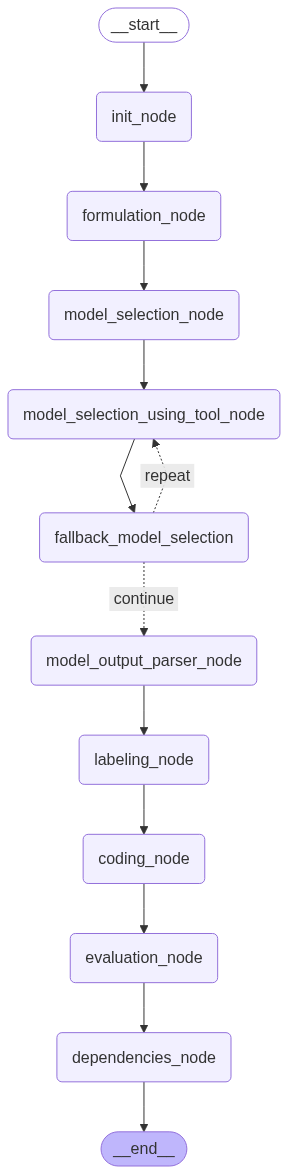

In [53]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [54]:
df_task

,STT,Task,Validation data
0,1,"""Bối cảnh của vấn đề:\r\nNhận dạng chữ viết ta...",Link
1,2,Bối cảnh của vấn đề:\r\nTrong thời đại thông t...,Link
2,3,Bối cảnh của vấn đề:\r\nĐây là một nhiệm vụ hồ...,Link
3,4,Bối cảnh của vấn đề:\r\nĐiều quan trọng là các...,Link
4,5,Bối cảnh của vấn đề:\r\nTrong nhiều ứng dụng t...,Link
5,6,🐾 Story: Alice’s Magical Pet Photo Box\r\nAlic...,Link


In [55]:
task_no = 4
task = df_task["Task"][task_no]

In [56]:
state = app.invoke({"task": task})

/tmp/ipykernel_3133/7332665.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desc = str(row[1]).replace("{", "{{").replace("}", "}}")
/tmp/ipykernel_3133/7332665.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  url = str(row[2])




> Entering new AgentExecutor chain...

Invoking: `web_scrapper` with `{'url': 'https://huggingface.co/zhaospei/Model_6'}`



🖼️ Mô hình Phân loại Ảnh - ViT Fine-tuned trên CIFAR-100
📝 Mô tả
Đây là mô hình Vision Transformer (ViT) được fine-tuned từ mô hình gốc google/vit-base-patch16-224-in21k trên tập dữ liệu CIFAR-100. Mô hình được huấn luyện để phân loại ảnh vào 100 lớp khác nhau, mỗi lớp đại diện cho một danh mục đối tượng cụ thể.
📌 Nhiệm vụ
Loại bài toán: Phân loại ảnh (Image Classification)
Số lớp: 100
Tập dữ liệu: CIFAR-100
📥 Đầu vào
Định dạng: Ảnh màu RGB
Kích thước ảnh:  224x224
📤 Đầu ra
Định dạng: Xác suất cho mỗi lớp (logits)
Kiểu dữ liệu: Tensor có kích thước [batch_size, 100]
Ý nghĩa: Xác suất dự đoán cho từng lớp trong 100 lớp của CIFAR-100
🛠 Yêu cầu thư viện
Cài đặt các thư viện cần thiết bằng:
pip install transformers torch torchvision
🧪 Cách sử dụng mô hình
Dưới đây là ví dụ về cách sử dụng mô hình để phân loại một ảnh:
import torch
from transformers import ViTForIma

In [57]:
ans = state['model_detailed_list']
for i in range(len(ans.models)):
    print(f"Model {i}:")
    pprint.pprint(ans.models[i].model_description)
    pprint.pprint(ans.models[i].model_input_format)
    pprint.pprint(ans.models[i].model_output_format)
    pprint.pprint(ans.models[i].model_requirements)
    pprint.pprint(ans.models[i].model_sample_code)

Model 0:
('Đây là mô hình Vision Transformer (ViT) được fine-tuned từ mô hình gốc '
 'google/vit-base-patch16-224-in21k trên tập dữ liệu CIFAR-100. Mô hình được '
 'huấn luyện để phân loại ảnh vào100 lớp khác nhau, mỗi lớp đại diện cho một '
 'danh mục đối tượng cụ thể.')
'Ảnh màu RGB có kích thước 224x224'
('Xác suất cho mỗi lớp (logits) với tensor có kích thước [batch_size,100], đại '
 'diện cho xác suất dự đoán cho từng lớp trong100 lớp của CIFAR-100')
('Cài đặt các thư viện cần thiết bằng: pip install transformers torch '
 'torchvision')
('```python\n'
 'import torch\n'
 'from transformers import ViTForImageClassification, ViTImageProcessor\n'
 'from PIL import Image\n'
 '\n'
 '# Tải ảnh cần phân loại\n'
 'image = Image.open("path_to_your_image.jpg")\n'
 '\n'
 '# Tải processor và mô hình từ Hugging Face\n'
 'processor = ViTImageProcessor.from_pretrained("zhaospei/Model_6")\n'
 'model = ViTForImageClassification.from_pretrained("zhaospei/Model_6")\n'
 '\n'
 '# Xử lý đầu vào\n'
 'inp

In [58]:
print(state['code'])

# Improved code with shape validation, resizing, batch processing, and input validation

import os
import csv
from PIL import Image
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from tqdm import tqdm

# Define the path to the images directory
images_dir = 'images'
output_csv = 'predictions.csv'

# List of all possible labels
labels = ['forest', 'orchid', 'spider', 'fox', 'caterpillar', 'crocodile', 'whale', 'road', 'motorcycle', 'tiger',
          'woman', 'orange', 'elephant', 'otter', 'flatfish', 'cup', 'sea', 'mountain', 'cloud', 'willow_tree',
          'rabbit', 'couch', 'maple_tree', 'wardrobe', 'mushroom', 'plain', 'telephone', 'shrew', 'bowl', 'tractor',
          'camel', 'bus', 'cattle', 'house', 'cockroach', 'lawn_mower', 'oak_tree', 'apple', 'bicycle', 'beetle',
          'palm_tree', 'sunflower', 'poppy', 'keyboard', 'porcupine', 'snake', 'can', 'pear', 'shark', 'chimpanzee',
          'hamster', 'train', 'cra', 'bear', 'sweet_pepper', 

In [59]:
print(state['dependencies'])

['pillow', 'torch', 'transformers', 'tqdm', 'pandas']
